In [55]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)  

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from ms.handler.metadata_source import TabzillaSource
from ms.metaresearch.meta_model import MetaModel
from ms.metaresearch.selectors.base import *
from ms.metaresearch.selectors.causal import *
from ms.metaresearch.selectors.model_based import *
from ms.metaresearch.selectors.model_free import *
from ms.metaresearch.selectors.model_wrapper import *
import random

from ms.metadataset.metadata_sampler import MetadataSampler
from ms.metaresearch.meta_learning import MetaLearner
from ms.metaresearch.plotting import Plotter
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [57]:
X = pd.read_csv('../resources/tabzilla/preprocessed/features__power.csv')
X = X.drop(columns=['dataset_name'])
X

,f__pymfe.statistical.nr_disc,f__pymfe.landmarking.linear_discr.mean,f__pymfe.model-based.leaves_per_class.min,f__pymfe.landmarking.linear_discr.max,f__pymfe.landmarking.worst_node.min,f__pymfe.model-based.leaves_per_class.max,f__pymfe.landmarking.elite_nn.max,f__pymfe.landmarking.elite_nn.mean,f__pymfe.model-based.var_importance.mean,f__pymfe.landmarking.worst_node.mean,...,f__pymfe.statistical.t_mean.min,f__pymfe.info-theory.class_ent,f__pymfe.landmarking.one_nn.skewness,f__pymfe.landmarking.linear_discr.kurtosis,f__pymfe.landmarking.one_nn.kurtosis,f__pymfe.landmarking.elite_nn.kurtosis,f__pymfe.landmarking.random_node.skewness,f__pymfe.general.nr_bin,f__pymfe.general.freq_class.skewness,f__pymfe.statistical.sparsity.skewness
0,-0.717694,-0.058807,0.300973,-0.079564,0.377100,0.325937,-0.032274,0.000554,-0.346265,0.354576,...,0.001745,-1.809913,-0.060385,-0.054699,0.011987,0.056088,0.045381,-0.853296,-0.191565,0.002694
1,-0.717694,0.331661,1.057782,0.367881,0.740437,0.434462,0.826934,1.012217,0.851732,1.047139,...,0.016592,-0.357676,1.098362,-1.021351,-0.555947,0.855549,0.123710,1.242876,-0.191565,-0.448708
2,1.259443,-1.817603,-0.986897,-1.902905,-1.003490,-1.269771,-1.487765,-1.321889,-0.921948,-1.065677,...,0.001690,0.862327,2.441022,0.364990,1.384655,-0.811672,0.987377,-0.853296,-0.393988,0.445351
3,1.591767,1.524092,-1.384178,1.181988,-1.404434,-1.512919,-1.618540,-1.479737,-0.205008,-1.502765,...,-0.003942,1.374531,1.383925,2.366672,2.342461,0.508524,-0.608309,-0.853296,1.237712,0.792441
4,1.548884,0.395620,-1.313345,0.528443,-1.330861,-1.745805,-1.836716,-1.835557,0.649553,-1.328979,...,0.004824,1.450634,-0.651210,-1.129312,0.390232,-0.654665,-0.479809,1.480583,-3.100597,-0.028891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1.259443,-2.557019,-1.474528,-2.391917,-1.829047,-1.879539,-2.532650,-2.508885,1.352984,-1.985215,...,-0.014311,1.694992,0.765007,-0.749477,-0.788399,0.402050,0.413781,-0.853296,2.107292,-1.141123
130,1.016480,-0.528458,-1.381179,-0.864932,-0.640228,-0.233640,-0.433528,-0.243242,-0.714794,-0.689973,...,0.008032,0.488152,0.279138,0.957285,0.014126,0.308066,0.657043,-0.853296,-0.454751,-0.038036
131,-0.717694,1.630453,0.765622,1.629772,0.645144,0.707926,1.702328,2.001674,-0.879193,2.079977,...,0.001723,-0.415777,-1.009984,1.566987,-1.482758,1.097915,0.168089,-0.853296,-0.191565,0.174857
132,-0.717694,-0.796536,0.932306,-0.968045,0.645144,0.547540,0.000875,0.153663,1.085436,0.354576,...,0.139038,-1.859142,-0.577274,-0.585525,-1.244723,-1.902582,0.045381,-0.853296,-0.191565,-0.489966


In [58]:
targets = pd.read_csv('../resources/tabzilla/preprocessed/metrics__diff.csv')
targets

,dataset_name,diff__rtdl_ResNet__XGBoost
0,openml__Amazon_employee_access__34539,1.0
1,openml__Australian__146818,0.0
2,openml__GesturePhaseSegmentationProcessed__14969,0.0
3,openml__JapaneseVowels__3510,1.0
4,openml__LED-display-domain-7digit__125921,1.0
...,...,...
129,openml__walking-activity__9945,0.0
130,openml__wall-robot-navigation__9960,0.0
131,openml__wdbc__9946,0.0
132,openml__wilt__146820,1.0


In [59]:
models = list(targets.columns)[1:]
#models = [models[2], models[5]]
models

['diff__rtdl_ResNet__XGBoost']

In [60]:
lr_mm = LogisticRegression()
params1 = {
            "penalty": "l2",
            "C": 0.05,
            "solver": "lbfgs",
        }
lr_mm.set_params(**params1)
params2 = params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        }
mlp_mm = MLPClassifier()
mlp_mm.set_params(**params2)

params3 = {
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
xgb_mm = XGBClassifier()
xgb_mm.set_params(**params3)
       
params4 = {
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
knn_mm = KNeighborsClassifier()
knn_mm.set_params(**params4)

KNeighborsClassifier(leaf_size=40, n_neighbors=6, p=1)

In [61]:
def get_explainer(model, X_train_sample):
    """Select appropriate SHAP explainer based on model type"""
    if isinstance(model, XGBClassifier):
        return shap.TreeExplainer(model)
    elif isinstance(model, LogisticRegression):
        return shap.LinearExplainer(model, X_train_sample)
    else:  # For MLP and KNN, use KernelExplainer
        return shap.KernelExplainer(model.predict_proba, X_train_sample)


In [62]:
mtls = [mlp_mm, xgb_mm, knn_mm]

In [63]:
result_df = pd.DataFrame(columns=['Target', 'MtL', 'FS method', 'Importance fraction score', 'Selection number', 'F1 score'])


In [64]:
init_features = list(X.columns)

In [65]:
def compute_shap_values(explainer, X_test_sample):
    """Compute SHAP values with appropriate method"""
    if isinstance(explainer, shap.LinearExplainer):
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values), axis=0)
        return mean_shap_values
    elif isinstance(explainer, shap.TreeExplainer):
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values), axis=0)
        return mean_shap_values
    else:  # KernelExplainer
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values[:,:,1]), axis=0)
        return mean_shap_values

In [66]:
def calculate_fraction(mean_shap_values, k_importance):
    sorted_indices = sorted(mean_shap_values, reverse=True)
    sum_all = np.sum(mean_shap_values)
    normilized_values = sorted_indices / sum_all
    sum_top = np.sum(normilized_values[0:k_importance])
    return sum_top 

In [67]:
selectors = [CorrelationSelector(md_source=None), CFSelector(md_source=None), FValueSelector(md_source=None), MutualInfoSelector(md_source=None), XGBSelector(md_source=None), LassoSelector(md_source=None), TESelector(md_source=None), BaseSelector(md_source=None)]

In [68]:
for m in models:
    print(m)
    y = targets[m].values
    for _ in range(3):
        print(_)
        X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3)
        for selector in selectors:        
            df_res = selector.handle_data(X_train, y_train, init_features)
            df_res.dropna(inplace=True)
            selected_f = list(df_res.index)
            if len(selected_f) != 0:
                selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]
                X_train_selected = X_train[:,selected_f_index]
                X_test_selected = X_test[:, selected_f_index]
                for mtl in mtls:
                    model_selected = mtl
                    model_selected.fit(X_train_selected, y_train)
                    explainer_selected = get_explainer(model_selected, X_test_selected)
                    shap_values_selected = compute_shap_values(explainer_selected, X_test_selected)
                    selector_score = calculate_fraction(shap_values_selected, 5)
                    f1_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                    df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Importance fraction score':[selector_score], 'Selection number':[len(selected_f)],'F1 score':[f1_selected]}
                    result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                    print(result_df)

diff__rtdl_ResNet__XGBoost
0


100%|██████████| 41/41 [00:12<00:00,  3.17it/s]
C:\Users\Irina\AppData\Local\Temp\ipykernel_20836\3797071259.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])


                       Target  \
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL    FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...  correlation   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL    FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...  correlation   
0  XGBClassifier(base_score=None, booster=None, c...  correlation   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
0                   0.674805               19  0.550000  


100%|██████████| 41/41 [00:13<00:00,  3.09it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL    FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...  correlation   
0  XGBClassifier(base_score=None, booster=None, c...  correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  correlation   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
0                   0.674805               19  0.550000  
0                   0.466413               19  0.666667  


100%|██████████| 41/41 [00:00<00:00, 89.98it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
0                   0.674805               19  0.550000  
0                   0.466413               19  0.666667  
0                   1.000000                5  0.578947  
                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResN

100%|██████████| 41/41 [00:00<00:00, 77.83it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
0                   0.674805               19  0.550000  
0                   0.466413               19  0.666667  
0                   1.000000   

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   
0  MLPClassifier(activation='logistic', alpha=0.0...         f_value   

   Importance fraction score Selection number  F1 score  
0                   0.497031               19  0.652174  
0                   0.674805              

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   
0  MLPClassifier(activation='logistic', alpha=0.0...         f_value   
0  XGBClassifier(base_score=None, booster=None, c...         f_value   
0  KNeighborsClassifi

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   
0  MLPClassifier(activation='logistic', alpha=0.0...         f_value   
0  XGBClassifier(base_score=None, booster=None, c...        

100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   
0  MLPClassifier(activation='logistic', alpha=0.0...         f_val

100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactual   
0  MLPClassifier(activation='logi

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNeighborsClassifier(leaf_size=40, n

100%|██████████| 41/41 [00:10<00:00,  3.75it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassifier(base_score=None, booster=None, c...  counterfactual   
0  KNe

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL       FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0  XGBClassifier(base_score=None, booster=None, c...     correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0  MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0  XGBClassi

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0  XGBClassifier(base_score=None, booster=None, c...       correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0  MLPClassifier(activation='logistic', alp

100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0  XGBClassifier(base_score=None, booster=None, c...       correlation   
0  KNeighborsClassifier(leaf_size=40, n_neighbors..

100%|██████████| 41/41 [00:27<00:00,  1.49it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0  XGBClassifier(base_score=None, booster=None, c...       correlation   
0  KNeighborsClass

100%|██████████| 41/41 [00:29<00:00,  1.37it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0  XGBClassifier(base_scor

100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0  MLPClassifier(activation='logistic', alpha=0.0...       correlat

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                                 MtL         FS method  \
0

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   

                                          

100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:01<00:00, 23.67it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:01<00:00, 21.13it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:10<00:00,  3.73it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:27<00:00,  1.48it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:30<00:00,  1.37it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:01<00:00, 23.69it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:01<00:00, 20.59it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                       Target  \
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__rtdl_ResNet__XGBoost   
0  diff__r

100%|██████████| 41/41 [00:00<00:00, 84.88it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_value   
0   MLP

100%|██████████| 41/41 [00:00<00:00, 74.98it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_info   
0   KNe

100%|██████████| 41/41 [00:11<00:00,  3.69it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_info   
0   MLP

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xgb   
0   KNe

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...             

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c...             

100%|██████████| 41/41 [00:27<00:00,  1.49it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...             

100%|██████████| 41/41 [00:30<00:00,  1.36it/s]

                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c...  treatment_e

In [69]:
result_df

,Target,MtL,FS method,Importance fraction score,Selection number,F1 score
0,diff__rtdl_ResNet__XGBoost,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,0.497031,19,0.652174
0,diff__rtdl_ResNet__XGBoost,"XGBClassifier(base_score=None, booster=None, c...",correlation,0.674805,19,0.550000
0,diff__rtdl_ResNet__XGBoost,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,0.466413,19,0.666667
0,diff__rtdl_ResNet__XGBoost,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,1.000000,5,0.578947
0,diff__rtdl_ResNet__XGBoost,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,1.000000,5,0.600000
...,...,...,...,...,...,...
0,diff__rtdl_ResNet__XGBoost,"XGBClassifier(base_score=None, booster=None, c...",treatment_effect,0.491390,25,0.487805
0,diff__rtdl_ResNet__XGBoost,"KNeighborsClassifier(leaf_size=40, n_neighbors...",treatment_effect,0.364653,25,0.375000
0,diff__rtdl_ResNet__XGBoost,"MLPClassifier(activation='logistic', alpha=0.0...",base,0.143647,123,0.571429
0,diff__rtdl_ResNet__XGBoost,"XGBClassifier(base_score=None, booster=None, c...",base,0.345648,123,0.514286


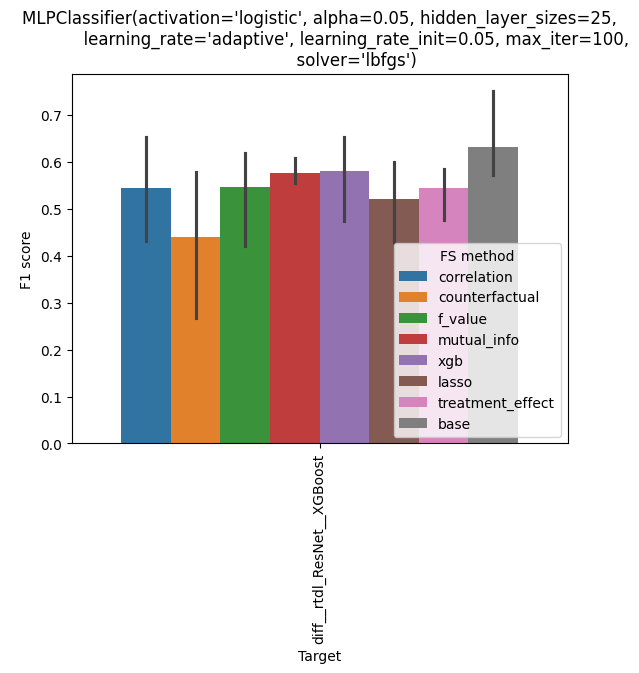

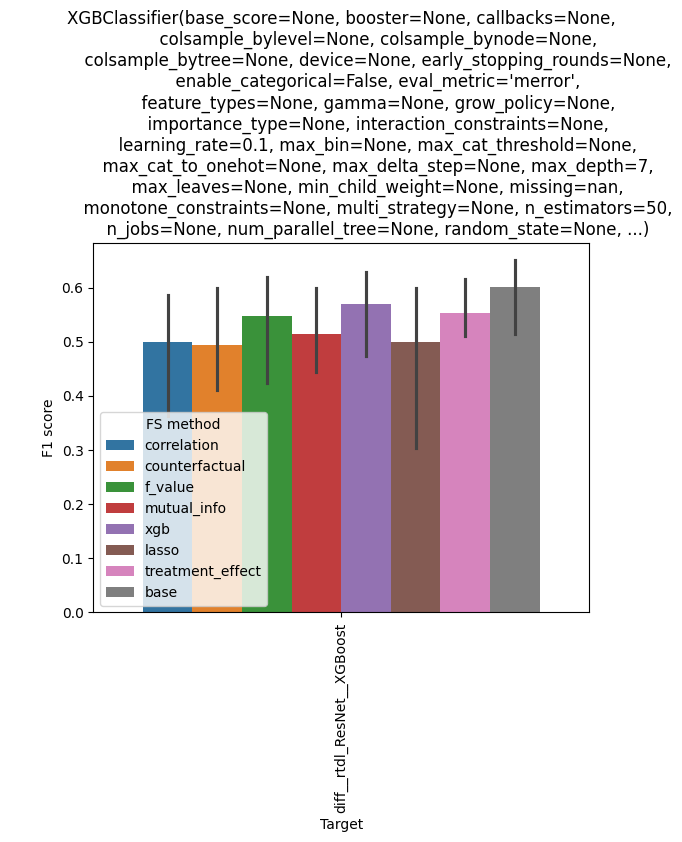

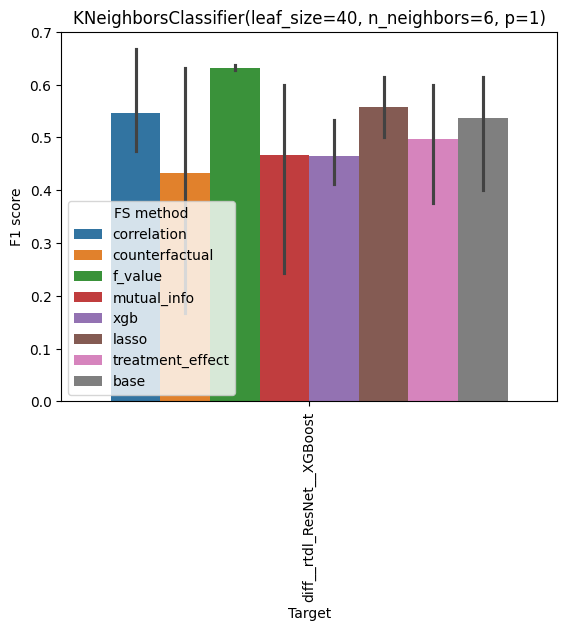

In [70]:
import seaborn as sns
for mtl in mtls:
    sample = result_df.loc[result_df['MtL'] == str(mtl)]
    plt.figure()
    plt.title(str(mtl))
    plt.xticks(rotation = 90)
    sns.barplot(x='Target', y='F1 score', hue='FS method', data=sample)
    

In [71]:
meta_models = [
MetaModel(
        name="mlp",
        display_name="MLP",
        model=MLPClassifier(),
        params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        },
),

MetaModel(
        name="xgb",
        display_name="XGBoost",
        model=XGBClassifier(),
        params={
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
),

MetaModel(
        name="knn",
        display_name="KNN",
        model=KNeighborsClassifier(),
        params={
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
)]

In [72]:
def mlp_importance_getter(estimator):
    # Sum absolute weights from input layer to first hidden layer
    return np.sum(np.abs(estimator.coefs_[0]), axis=1)

In [73]:
for m in models:
    print(m)
    y = targets[m].values
    for _ in range(3):
        print(_)
        X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3)
        for i, mtl in enumerate(mtls):
            if meta_models[i].name != 'knn':
                selector = RFESelector(md_source=None, model=mtl)
                if meta_models[i].name == 'mlp':
                    selector = RFESelector(md_source=None, model=mtl, importance_getter=mlp_importance_getter)
                df_res = selector.handle_data(X_train, y_train, init_features)
                df_res.dropna(inplace=True)
                selected_f = list(df_res.index)
                selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]

                X_train_selected = X_train[:,selected_f_index]
                X_test_selected = X_test[:, selected_f_index]
                model_selected = mtl
                model_selected.fit(X_train_selected, y_train)
                explainer_selected = get_explainer(model_selected, X_test_selected)
                shap_values_selected = compute_shap_values(explainer_selected, X_test_selected)
                selector_score = calculate_fraction(shap_values_selected, 5)
                f1_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Importance fraction score':[selector_score], 'Selection number':[len(selected_f)], 'F1 score':[f1_selected]}
                result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                print(result_df)


diff__rtdl_ResNet__XGBoost
0


100%|██████████| 41/41 [00:18<00:00,  2.18it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  treatment_e

100%|██████████| 41/41 [00:18<00:00,  2.21it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            base   
0   KNe

100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


                        Target  \
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
..                         ...   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   
0   diff__rtdl_ResNet__XGBoost   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rfe   
0   XGB

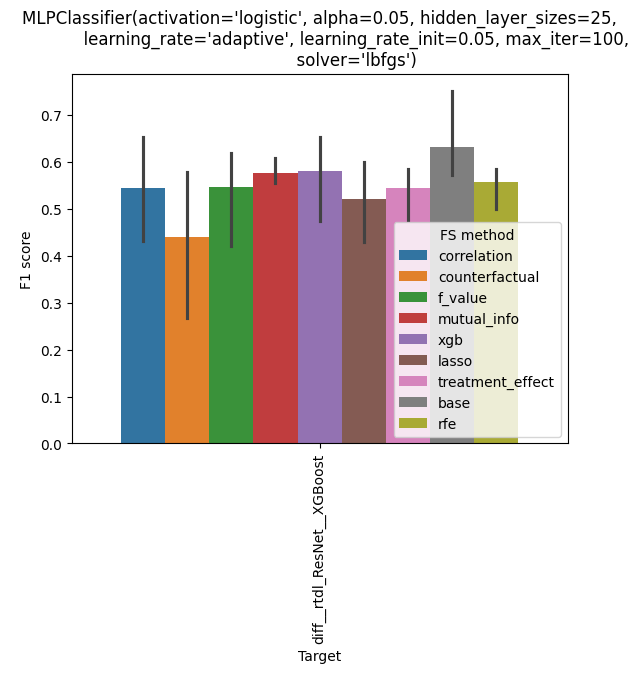

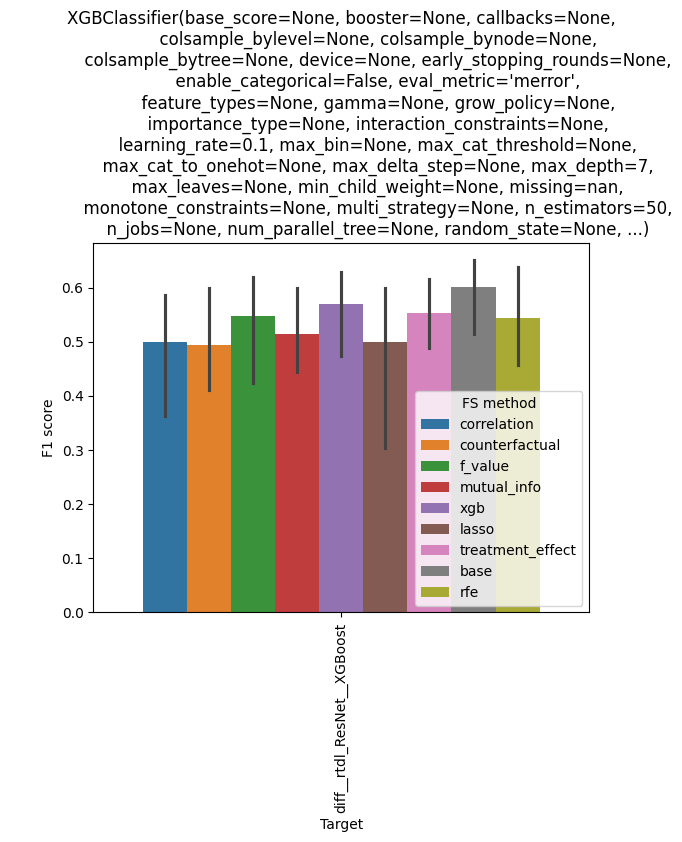

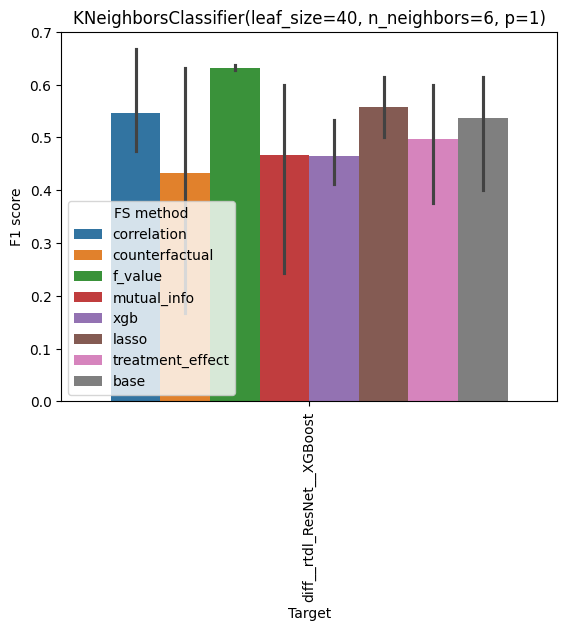

In [74]:
import seaborn as sns
for mtl in mtls:
    sample = result_df.loc[result_df['MtL'] == str(mtl)]
    plt.figure()
    plt.title(str(mtl))
    plt.xticks(rotation = 90)
    sns.barplot(x='Target', y='F1 score', hue='FS method', data=sample)
    

In [75]:
result_df.to_csv('interpret_f1_perf_diff.csv', index=False)